## Feature Engineering and Modelling
After the outbreak of severe acute respiratory syndrome (SARS-2002/2003) and middle east respiratory syndrome (MERS-2012/2014) in the world, new public health crisis, called new coronavirus disease (COVID-19), started in China in December 2019 and has spread all over countries. COVID-19 coronavirus has been global threat of the disease and infected humans rapidly. Control of the pandemic is urgently essential, and science community have continued to research treatment agents. Support therapy and intensive care units in hospitals are also efective to overcome of COVID-19. Statistic forecasting models could aid to healthcare system in preventation of COVID-19. This study aimed to compose of forecasting model that could be practical to predict the spread of COVID-19 in USA,India and Brazil which are leading countries. For this purpose ,I will be using ARIMA ,SARIMA,Exponential Smoothing AND FACEBOOK PROPHET model.



In [ ]:
## Loading neccessay modules and library

In [ ]:
!pip install pmdarima

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import datetime as dt
from datetime import timedelta
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from fbprophet import Prophet
from statsmodels.tsa.stattools import adfuller
#!pip install pyramid-arima

from pmdarima.arima import ADFTest
std=StandardScaler()

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# loading and reading the file.
final_dataset=pd.read_csv('/content/drive/My Drive/capstone1/final_dataset.csv')
# final_dataset=pd.read_csv("https://reeti2020.s3.amazonaws.com/final_dataset.csv")

In [4]:
df_data=final_dataset.groupby("Date").agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})

In [5]:

#  checking using .sample
df_data.sample(3)

,Confirmed,Recovered,Deaths
Date,,,
2020-04-18,2331380,578424,164598
2020-06-15,8041943,3794064,437591
2020-09-16,29871738,20188396,940724


In [6]:
df_data.index=pd.to_datetime(df_data.index)

## Time Series Forecasting
It is a series of observations taken at specified times basically at equal intervals. It is used to predict future values based on past observed values. The components you might observe in the time-series analysis are Trend, Seasonal, Irregular, and Cyclicity.
In the case of such datasets where only one variable is observed at each time is called ‘Univariate Time Series’ and if two or more variables are observed at each time is called ‘Multivariate Time Series’.

## Forecasting with different Time series models and comparing the accuracies to find the best model for covid19 dataset.
“Prediction is very difficult, especially about the future”.
Forecasting is the process of making predictions of the future, based on past and present data. One of the most common methods for this is the ARIMA model, which stands for AutoRegressive Integrated Moving Average. I will be using expoential smooting,AUTO-ARIMA,SARIMA AND PROPHET.

## Holt's Winter Time Series analysis

Exponential smoothing is a time series forecasting method for univariate data that can be extended to support data with a systematic trend or seasonal component.

It is a powerful forecasting method that may be used as an alternative to the popular Box-Jenkins ARIMA family of methods.

The implementations of Exponential Smoothing in Python are provided in the Statsmodels Python library.

### Double and Triple Exponential Smoothing
Single, Double and Triple Exponential Smoothing can be implemented in Python using the ExponentialSmoothing Statsmodels class.

First, an instance of the ExponentialSmoothing class must be instantiated, specifying both the training data and some configuration for the model.

Specifically, you must specify the following configuration parameters:

trend: The type of trend component, as either “add” for additive or “mul” for multiplicative. Modeling the trend can be disabled by setting it to None.
damped: Whether or not the trend component should be damped, either True or False.
seasonal: The type of seasonal component, as either “add” for additive or “mul” for multiplicative. Modeling the seasonal component can be disabled by setting it to None.
seasonal_periods: The number of time steps in a seasonal period, e.g. 12 for 12 months in a yearly seasonal structure (more here).
The model can then be fit on the training data by calling the fit() function.

This function allows you to either specify the smoothing coefficients of the exponential smoothing model or have them optimized. By default, they are optimized (e.g. optimized=True). These coefficients include:

smoothing_level (alpha): the smoothing coefficient for the level.
smoothing_slope (beta): the smoothing coefficient for the trend.
smoothing_seasonal (gamma): the smoothing coefficient for the seasonal component.
damping_slope (phi): the coefficient for the damped trend.
Additionally, the fit function can perform basic data preparation prior to modeling; specifically:

use_boxcox: Whether or not to perform a power transform of the series (True/False) or specify the lambda for the transform.
The fit() function will return an instance of the HoltWintersResults class that contains the learned coefficients. The forecast() or the predict() function on the result object can be called to make a forecast.



In [7]:
# train and test split
model_train=df_data.iloc[:int(df_data.shape[0]*0.95)]
valid=df_data.iloc[int(df_data.shape[0]*0.95):]
y_pred=valid.copy()

In [8]:

# using exponentialSmoothing model
es=ExponentialSmoothing(np.asarray(model_train['Confirmed']),seasonal_periods=11,trend='mul', seasonal='add').fit()

In [10]:
#predicting using .forecast and checking model scores

model_scores=[]
model_holts=pd.DataFrame(es.forecast(steps=15),index=valid.index)
y_pred["Holt's Winter Model"]=model_holts
model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt's Winter Model"])))
print("Root Mean Square Error for Holt's Winter Model: ",np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt's Winter Model"])))

Root Mean Square Error for Holt's Winter Model:  69257.27817499872


In [11]:
#plots
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["Holt's Winter Model"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases Holt's Winter Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

## AUTO ARIMA MODEL

Usually, in the basic ARIMA model, we need to provide the p,d, and q values which are essential. We use statistical techniques to generate these values by performing the difference to eliminate the non-stationarity and plotting ACF and PACF graphs. In Auto ARIMA, the model itself will generate the optimal p, d, and q values which would be suitable for the data set to provide better forecasting.

from pmdarima.arima import auto_arima  is imported.

Auto-Regressive (p) -> Number of autoregressive terms.

Integrated (d) -> Number of nonseasonal differences needed for stationarity.

Moving Average (q) -> Number of lagged forecast errors in the prediction equation.

In the Auto ARIMA model, note that small p,d,q values represent non-seasonal components, and capital P, D, Q represent seasonal components. It works similarly like hyper tuning techniques to find the optimal value of p, d, and q with different combinations and the final values would be determined with the lower AIC, BIC parameters taking into consideration.

Here, we are trying with the p, d, q values ranging from 0 to 5 to get better optimal values from the model. 


In [12]:
# Train test split
model_train=df_data.iloc[:int(df_data.shape[0]*0.95)]
valid=df_data.iloc[int(df_data.shape[0]*0.95):]
y_pred=valid.copy()

In [ ]:
! pip install pmdarima

In [13]:
# using auto-arima model
from pmdarima.arima import auto_arima
model_arima= auto_arima(model_train["Confirmed"],trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,
                   suppress_warnings=True,stepwise=False,seasonal=False)
results=model_arima.fit(model_train["Confirmed"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=6209.934, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=6190.302, Time=0.16 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=6219.382, Time=0.16 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=6219.724, Time=0.40 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=6210.206, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=6186.480, Time=0.17 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=6230.001, Time=0.19 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=6302.176, Time=0.33 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=6199.989, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=6151.217, Time=0.21 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=6281.902, Time=0.37 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=6153.584, Time=0.58 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=6174.706, Time=0.08 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=6120.924, Time=0.21 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=6229.222, Time=1.14 sec
Total fit 

In [14]:
# checking summary of model

model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  272
Model:               SARIMAX(3, 2, 1)   Log Likelihood               -3054.462
Date:                Thu, 05 Nov 2020   AIC                           6120.924
Time:                        07:18:14   BIC                           6142.515
Sample:                             0   HQIC                          6129.594
                                - 272                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2644.1162    660.812      4.001      0.000    1348.949    3939.283
ar.L1          0.2698      0.064      4.222      0.000       0.145       0.395
ar.L2         -0.2072      0.063     -3.290      0.001      -0.331      -0.084
ar.L3         -0.4025      0.079     -5.087      0.000      -0.558      -0.247
ma.L1         -0.6860      0.072     -9.561      0.000      -0.827      -0.545
sigma2      4.894e+08      0.000   2.18e+12      0.000    4.89e+08    4.89e+08
===================================================================================
Ljung-Box (Q):                      286.47   Jarque-Bera (JB):               881.28
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              12.16   Skew:                             1.32
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.24e+29. Standard errors may be unstable.
"""

In [15]:
# prediction of test data
arima_prediction=pd.DataFrame(model_arima.predict(len(valid)),index=valid.index,columns=["Arima predictions"])
arima_prediction.head()

,Arima predictions
Date,
2020-10-20,4.083507e+07
2020-10-21,4.126596e+07
2020-10-22,4.163555e+07
2020-10-23,4.199348e+07
2020-10-24,4.236647e+07


In [16]:
# checking accuracy of model by metrics rmse
model_scores.append(np.sqrt(mean_squared_error(valid["Confirmed"],arima_prediction)))
y_pred["ARIMA Model Prediction"]=arima_prediction
print("Root Mean Square Error for ARIMA Model: ",np.sqrt(mean_squared_error(valid["Confirmed"],arima_prediction)))

Root Mean Square Error for ARIMA Model:  569902.8350272006


In [17]:
# plots
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["ARIMA Model Prediction"],
                    mode='lines+markers',name="Prediction for Confirmed Cases",))
fig.update_layout(title="Confirmed Cases ARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

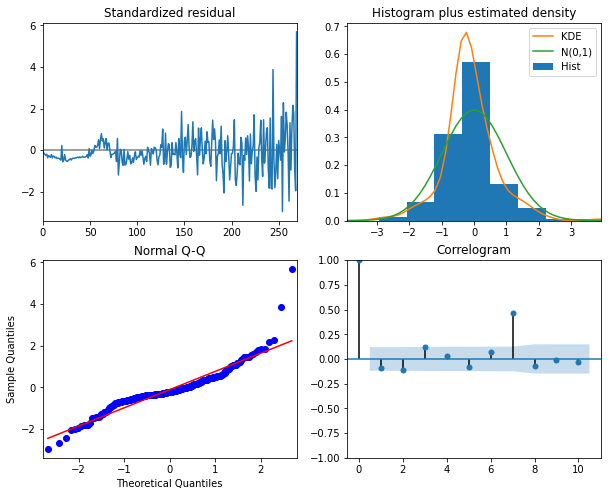

In [18]:
results.plot_diagnostics(figsize=(10,8))
plt.show()

## SARIMA
In order to do this we will need to choose p,d,q values for the ARIMA, and P,D,Q values for the Seasonal component.

There are many ways to choose these values statistically, such as looking at auto-correlation plots, correlation plots, domain experience, etc.

One simple approach is to perform a grid search over multiple values of p,d,q,P,D,and Q using some sort of performance criteria. The Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models.

The AIC value will allow us to compare how well a model fits the data and takes into account the complexity of a model, so models that have a better fit while using fewer features will receive a better (lower) AIC score than similar models that utilize more features.

The pyramid-arima library for Python allows us to quickly perform this grid search and even creates a model object that you can fit to the training data. It is similar alike arima but seasonality is true here.

In [19]:
#Test for stationary
from pmdarima.arima import ADFTest
adf_test=ADFTest(alpha=0.05)
adf_test.should_diff(df_data["Confirmed"])

(0.99, True)

In [20]:
#train-test split
model_train=df_data.iloc[:int(df_data.shape[0]*0.95)]
valid=df_data.iloc[int(df_data.shape[0]*0.95):]
y_pred=valid.copy()

In [21]:
# sarima model.fit()
model_sarima=auto_arima(model_train["Confirmed"],trace=True,error_action='ignore',
                        start_p=0,start_q=0,max_p=2,max_q=2,m=7,suppress_warnings=True,stepwise=True,seasonal=True)
result=model_sarima.fit(model_train["Confirmed"])

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[7]             : AIC=6019.723, Time=0.18 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=6209.213, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=6087.982, Time=0.15 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=6117.624, Time=0.17 sec
 ARIMA(0,2,0)(0,0,1)[7]             : AIC=6155.762, Time=0.08 sec
 ARIMA(0,2,0)(1,0,0)[7]             : AIC=6074.367, Time=0.06 sec
 ARIMA(0,2,0)(2,0,1)[7]             : AIC=6018.037, Time=0.40 sec
 ARIMA(0,2,0)(2,0,0)[7]             : AIC=6033.332, Time=0.25 sec
 ARIMA(0,2,0)(2,0,2)[7]             : AIC=6017.761, Time=0.86 sec
 ARIMA(0,2,0)(1,0,2)[7]             : AIC=6025.383, Time=0.51 sec
 ARIMA(1,2,0)(2,0,2)[7]             : AIC=6061.683, Time=1.22 sec
 ARIMA(0,2,1)(2,0,2)[7]             : AIC=inf, Time=3.17 sec
 ARIMA(1,2,1)(2,0,2)[7]             : AIC=6026.536, Time=1.54 sec
 ARIMA(0,2,0)(2,0,2)[7] intercept   : AIC=inf, Time=1.55 sec

Best model:  ARIMA(0,2,0)(2,0,2)[7]       

In [22]:

# checking summary of model
model_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  272
Model:             SARIMAX(0, 2, 0)x(2, 0, [1, 2], 7)   Log Likelihood               -3003.881
Date:                                Thu, 05 Nov 2020   AIC                           6017.761
Time:                                        07:19:00   BIC                           6035.753
Sample:                                             0   HQIC                          6024.986
                                                - 272                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        1.8039      0.293      6.157      0.000       1.230       2.378
ar.S.L14      -0.8163      0.295     -2.769      0.006      -1.394      -0.238
ma.S.L7       -1.5551      0.278     -5.590      0.000      -2.100      -1.010
ma.S.L14       0.6804      0.176      3.871      0.000       0.336       1.025
sigma2      3.177e+08   2.04e-09   1.56e+17      0.000    3.18e+08    3.18e+08
===================================================================================
Ljung-Box (Q):                       93.67   Jarque-Bera (JB):              1028.70
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              16.94   Skew:                             1.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.57e+32. Standard errors may be unstable.
"""

In [23]:
#predictions using .predict on test data
sarima_prediction=pd.DataFrame(model_sarima.predict(len(valid)),index=valid.index,columns=["Sarima predictions"])
y_pred["SARIMA Model Prediction"]=sarima_prediction
sarima_prediction.head()

,Sarima predictions
Date,
2020-10-20,4.082716e+07
2020-10-21,4.128414e+07
2020-10-22,4.176564e+07
2020-10-23,4.224112e+07
2020-10-24,4.268534e+07


In [24]:
# checking accuracy
model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["SARIMA Model Prediction"])))
print("Root Mean Square Error for SARIMA Model: ",np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["SARIMA Model Prediction"])))

Root Mean Square Error for SARIMA Model:  59495.16728992984


In [25]:
#plots
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["SARIMA Model Prediction"],
                    mode='lines+markers',name="Prediction for Confirmed Cases",))
fig.update_layout(title="Confirmed Cases SARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

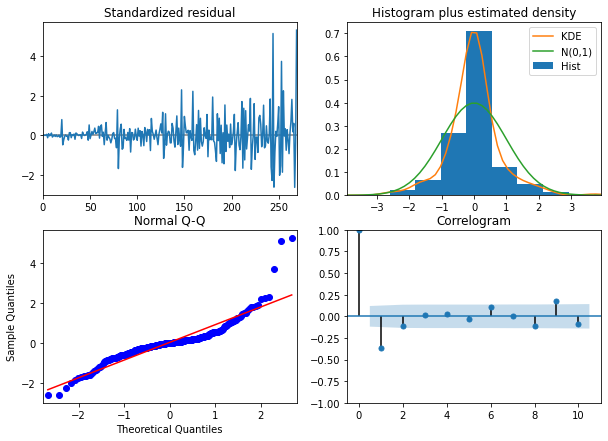

In [26]:
result.plot_diagnostics(figsize=(10,7))
plt.show()


## Prophet
We use Prophet, a procedure for forecasting time series data based on an additive model where non_linear trends are fit with yearly,weekly,and daily seasonality,plus holiday effects.it works best with time series that have strong seasonal effects and several effects and several seasons of historical data.It is robust to missing data and shifts in the trend and typically hadles outliers.

In [27]:
confirmed=final_dataset.groupby('Date').sum()["Confirmed"].reset_index()
deaths=final_dataset.groupby("Date").sum()["Deaths"].reset_index()
recovered=final_dataset.groupby("Date").sum()["Recovered"].reset_index()

The input to Prophet is always a dataframe with two columns:ds and y.The ds(datestamp) column should be of a format expected by Pandas.The y column must be numeric, and represents the measurements we wish to forecast.



In [28]:
def rename_func(dataframe):
    cols=dataframe.columns
    dataframe=dataframe.rename(columns ={cols[0] :'ds',cols[1]:"y"})
    return dataframe

In [29]:
df_confirmed=rename_func(confirmed)
df_confirmed.head()

,ds,y
0,2020-01-22,555
1,2020-01-23,654
2,2020-01-24,941
3,2020-01-25,1434
4,2020-01-26,2118


In [30]:
#traintest split
model_train=df_confirmed.iloc[:int(df_data.shape[0]*0.95)]
valid=df_confirmed[int(df_data.shape[0]*0.95):]
y_pred=valid.copy()

In [31]:
model_train.shape,valid.shape

((272, 2), (15, 2))

In [32]:
#prophet_model
model=Prophet(interval_width=0.95)
model.add_seasonality(name="Monthly",period=30.42,fourier_order=5)

In [33]:

# model_fit
model.fit(model_train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [34]:
#forecast
future_dates=model.make_future_dataframe(periods=10)
forecast_confirmed=future_dates.copy()

In [35]:
prophet_forecast=model.predict(future_dates)


In [36]:
prophet_forecast.yhat.tail()

277    4.151952e+07
278    4.179786e+07
279    4.206305e+07
280    4.235676e+07
281    4.266130e+07
Name: yhat, dtype: float64

In [37]:
## checking accuracy
model_scores.append(np.sqrt(mean_squared_error(valid["y"],prophet_forecast['yhat'].head(valid.shape[0]))))
print("Root Mean Squared Error for Prophet Model: ",np.sqrt(mean_squared_error(valid["y"],prophet_forecast['yhat'].head(valid.shape[0]))))

Root Mean Squared Error for Prophet Model:  44111558.95600259


Figure(720x432)


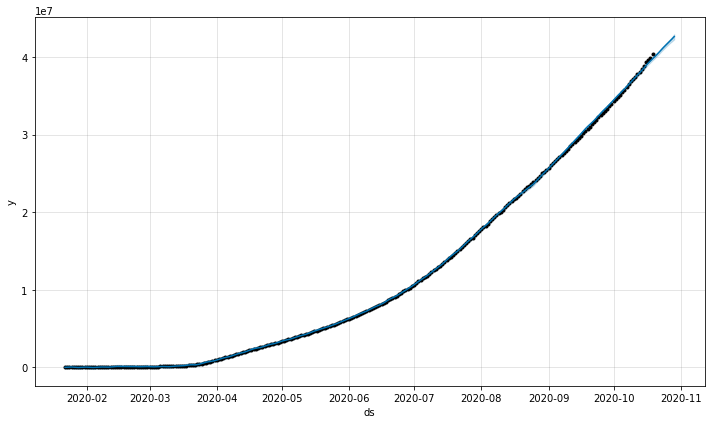

In [38]:
#plots

print(model.plot(prophet_forecast))

Figure(648x648)


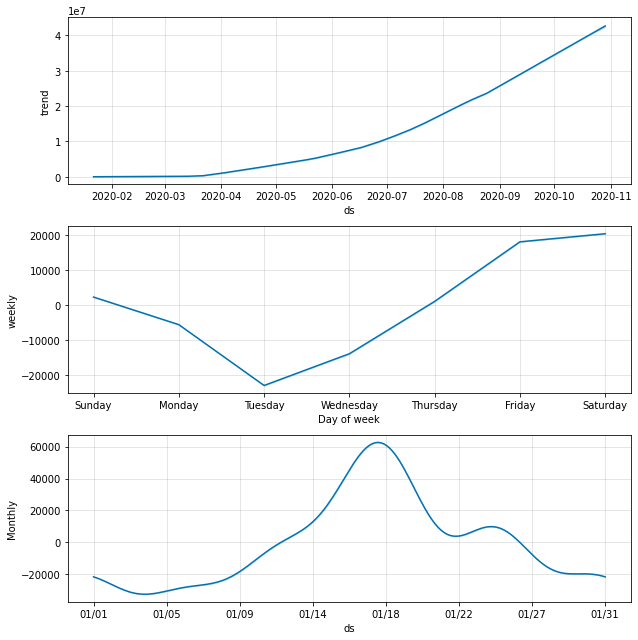

In [39]:
print(model.plot_components(prophet_forecast))

## Summarization of Forecasts using different Models¶

In [40]:
model_names=["Holt's Winter Model","ARIMA Model","SARIMA Model","Facebook's Prophet Model"]
model_summary=pd.DataFrame(zip(model_names,model_scores),columns=["Model Name","Root Mean Squared Error"]).sort_values(["Root Mean Squared Error"])
model_summary

,Model Name,Root Mean Squared Error
2,SARIMA Model,5.949517e+04
0,Holt's Winter Model,6.925728e+04
1,ARIMA Model,5.699028e+05
3,Facebook's Prophet Model,4.411156e+07


RMSE  of SARIMA Model  has good accuracy with rmse 5.949517 and AIC score 6017.  so I will be using SARIMA model to forecast covid19  cases.

### Time Series Forecasting for Death Cases using SARIMA model

In [41]:
#Test for stationary
from pmdarima.arima import ADFTest
adf_test=ADFTest(alpha=0.05)
adf_test.should_diff(df_data["Deaths"])

(0.08508417754047438, True)

In [42]:
#traintest split
model_train=df_data.iloc[:int(df_data.shape[0]*0.95)]
valid=df_data[int(df_data.shape[0]*0.95):]
y_pred=valid.copy()

In [43]:
#sarima model.fit()
model_sarima_deaths=auto_arima(model_train["Deaths"],trace=True,error_action='ignore',
                        start_p=0,start_q=0,max_p=2,max_q=2,m=7,suppress_warnings=True,stepwise=True,seasonal=True)
model_sarima_deaths.fit(model_train["Deaths"])

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[7]             : AIC=4496.344, Time=0.42 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=4577.618, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=4497.424, Time=0.20 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=4487.715, Time=0.29 sec
 ARIMA(0,2,1)(0,0,0)[7]             : AIC=4542.632, Time=0.07 sec
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=4394.136, Time=0.74 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=4442.274, Time=0.27 sec
 ARIMA(0,2,1)(2,0,1)[7]             : AIC=4395.892, Time=1.61 sec
 ARIMA(0,2,1)(1,0,2)[7]             : AIC=4395.913, Time=2.26 sec
 ARIMA(0,2,1)(0,0,2)[7]             : AIC=4454.764, Time=0.83 sec
 ARIMA(0,2,1)(2,0,0)[7]             : AIC=4419.060, Time=0.51 sec
 ARIMA(0,2,1)(2,0,2)[7]             : AIC=inf, Time=2.67 sec
 ARIMA(1,2,1)(1,0,1)[7]             : AIC=4395.602, Time=0.94 sec
 ARIMA(0,2,2)(1,0,1)[7]             : AIC=4395.567, Time=1.13 sec
 ARIMA(1,2,0)(1,0,1)[7]             : 

ARIMA(maxiter=50, method='lbfgs', order=(1, 2, 2), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(1, 0, 1, 7),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [59]:
#predictions using .predict on test data
sarima_prediction_deaths=pd.DataFrame(model_sarima_deaths.predict(len(valid)),index=valid.index,columns=["Sarima Deaths predictions"])
y_pred["SARIMA Model Deaths Prediction"]=sarima_prediction_deaths
sarima_prediction_deaths.head()

,Sarima Deaths predictions
Date,
2020-10-20,1.123814e+06
2020-10-21,1.129608e+06
2020-10-22,1.135810e+06
2020-10-23,1.141550e+06
2020-10-24,1.146684e+06


In [57]:
#plots
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Deaths"],
                    mode='lines+markers',name="Train Data for Death Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Deaths"],
                    mode='lines+markers',name="Validation Data for Death Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["SARIMA Model Deaths Prediction"],
                    mode='lines+markers',name="Prediction for Death Cases",))
fig.update_layout(title="Death Cases SARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Death Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [58]:
print("Root Mean Square Error: ",np.sqrt(mean_squared_error(valid["Deaths"],sarima_prediction_deaths)))


Root Mean Square Error:  7919.090467064861


## Forecasting 30 days  deaths cases

In [48]:
#modelling 
model_sarima_death=auto_arima(df_data["Deaths"],trace=True,error_action='ignore',
                        start_p=0,start_q=0,max_p=2,max_q=2,m=7,suppress_warnings=True,stepwise=True,seasonal=True)
model_sarima_death.fit(df_data["Deaths"])





Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[7]             : AIC=4736.564, Time=0.51 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=4832.828, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=4739.658, Time=0.19 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=4733.882, Time=0.32 sec
 ARIMA(0,2,1)(0,0,0)[7]             : AIC=4797.605, Time=0.08 sec
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=4629.112, Time=0.75 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=4680.554, Time=0.26 sec
 ARIMA(0,2,1)(2,0,1)[7]             : AIC=4633.243, Time=1.83 sec
 ARIMA(0,2,1)(1,0,2)[7]             : AIC=4630.354, Time=2.74 sec
 ARIMA(0,2,1)(0,0,2)[7]             : AIC=4696.114, Time=0.90 sec
 ARIMA(0,2,1)(2,0,0)[7]             : AIC=4656.362, Time=0.75 sec
 ARIMA(0,2,1)(2,0,2)[7]             : AIC=inf, Time=2.40 sec
 ARIMA(1,2,1)(1,0,1)[7]             : AIC=4630.735, Time=1.78 sec
 ARIMA(0,2,2)(1,0,1)[7]             : AIC=4630.412, Time=0.96 sec
 ARIMA(1,2,0)(1,0,1)[7]             : 

ARIMA(maxiter=50, method='lbfgs', order=(1, 2, 2), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(1, 0, 1, 7),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [50]:
#forecasting 30 days deaths cases
future_dates=pd.date_range(start="2020-11-04",end="2020-12-04")
future_forecast_deaths=pd.DataFrame(model_sarima_death.predict(31),index=future_dates[0:],columns=["Deaths"]).reset_index()
#future_forecast_deaths
future_forecast_deaths=future_forecast_deaths.rename(columns={"index":"Date"})
future_forecast_deaths.set_index('Date',inplace=True)
future_forecast_deaths.tail(5)

,Deaths
Date,
2020-11-30,1.415551e+06
2020-12-01,1.424135e+06
2020-12-02,1.432704e+06
2020-12-03,1.441401e+06
2020-12-04,1.450054e+06


In [51]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=df_data.index, y=df_data["Deaths"],
                    mode='lines+markers',name=" Data for Death Cases"))
fig.add_trace(go.Scatter(x=future_forecast_deaths.index, y=future_forecast_deaths["Deaths"],
                    mode='lines+markers',name=" Data for Death Cases",))
fig.update_layout(title="Death Cases SARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Death Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()


It seems it decreases first and then  increases with the number of days. However ,in time series analysis can be done considering endogenous and exogenous variables but I have only considered endogenous variables.

## Forecasting 30 days of Confirmed cases

In [52]:
model_sarima=auto_arima(df_data["Confirmed"],trace=True,error_action='ignore',
                        start_p=0,start_q=0,max_p=2,max_q=2,m=7,suppress_warnings=True,stepwise=True,seasonal=True)
model_sarima.fit(df_data["Confirmed"])


future_forecast_confirmed=pd.DataFrame(model_sarima.predict(31),index=future_dates[0:],columns=["Confirmed"]).reset_index()
future_forecast_confirmed=future_forecast_confirmed.rename(columns={"index":"Date"})
future_forecast_confirmed.set_index('Date',inplace=True)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[7]             : AIC=6438.906, Time=0.17 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=6650.438, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=6495.926, Time=0.13 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=6524.547, Time=0.13 sec
 ARIMA(0,2,0)(0,0,1)[7]             : AIC=6556.424, Time=0.09 sec
 ARIMA(0,2,0)(1,0,0)[7]             : AIC=6469.845, Time=0.06 sec
 ARIMA(0,2,0)(2,0,1)[7]             : AIC=6440.348, Time=0.39 sec
 ARIMA(0,2,0)(1,0,2)[7]             : AIC=6445.226, Time=0.50 sec
 ARIMA(0,2,0)(0,0,2)[7]             : AIC=6553.720, Time=0.26 sec
 ARIMA(0,2,0)(2,0,0)[7]             : AIC=6454.559, Time=0.19 sec
 ARIMA(0,2,0)(2,0,2)[7]             : AIC=6441.594, Time=0.92 sec
 ARIMA(1,2,0)(1,0,1)[7]             : AIC=6480.746, Time=0.23 sec
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=6465.056, Time=0.28 sec
 ARIMA(1,2,1)(1,0,1)[7]             : AIC=6457.900, Time=0.48 sec
 ARIMA(0,2,0)(1,0,1)[7] intercept

In [53]:
future_forecast_confirmed.tail(5)

,Confirmed
Date,
2020-11-30,6.109157e+07
2020-12-01,6.161408e+07
2020-12-02,6.217187e+07
2020-12-03,6.275375e+07
2020-12-04,6.334820e+07


In [54]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=df_data.index, y=df_data["Confirmed"],
                    mode='lines+markers',name=" Data for Death Cases"))
fig.add_trace(go.Scatter(x=future_forecast_confirmed.index, y=future_forecast_confirmed["Confirmed"],
                    mode='lines+markers',name=" Data for Death Cases",))
fig.update_layout(title="Confirmed Cases SARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases")
fig.show()

In conclusion, in univariate timeseries model sarima model has good accuracy and results.